In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [67]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'learning rate':0.01,
        'training epochs':5000,

        'training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [68]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [69]:
df = pd.read_excel('data_3nm.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [70]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [71]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [72]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [73]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

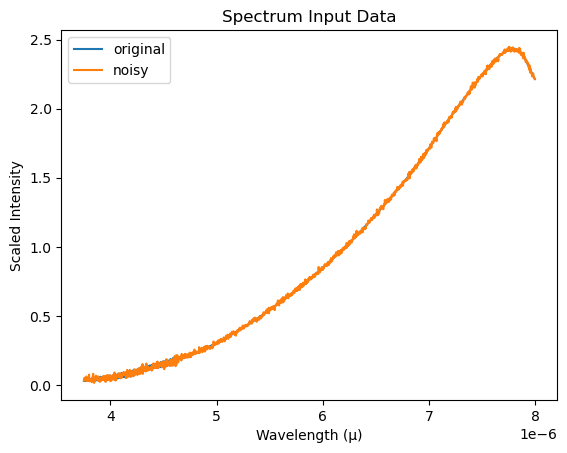

In [74]:
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [75]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [76]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [77]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.426395,0.465126,1.192863,0.087989,1.031311,1.387851,1.055384,0.808905,1.566041,0.163538,...,-0.315837,-0.327787,-0.309995,-0.304528,-0.299122,-0.310289,-0.311892,-0.312761,-0.315933,-0.312711
1,0.461600,0.183916,0.309175,-0.481151,0.753190,-0.367034,-0.832945,-0.429797,0.185811,-1.280101,...,-0.804354,-0.800736,-0.796933,-0.812093,-0.796260,-0.790815,-0.793270,-0.811305,-0.795082,-0.809757
2,-0.695115,-0.082416,0.575717,0.463259,-0.551752,0.866745,0.120236,0.784736,-0.124112,0.779631,...,1.288977,1.268230,1.270433,1.269621,1.280192,1.269740,1.280715,1.277279,1.253763,1.278737
3,-1.828500,0.417973,-1.371186,-1.885687,-1.658119,-0.617036,-0.388697,-1.650507,-0.626559,-0.814880,...,0.024368,0.012818,0.033059,0.029738,0.029759,0.045692,0.033519,0.032443,0.037347,0.029990
4,0.616161,0.788424,-0.601397,0.612799,-0.359692,-0.151446,0.176816,-0.281220,0.522621,-0.491902,...,0.298250,0.290247,0.298647,0.293804,0.296182,0.285452,0.294451,0.286736,0.282881,0.287421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-0.278804,0.841295,0.152483,-0.433307,0.726119,1.722139,-0.232619,1.282959,0.288070,0.306271,...,1.362934,1.374206,1.361022,1.360938,1.368281,1.372582,1.353509,1.350569,1.377795,1.366871
2196,1.060241,-0.958164,1.168452,0.715623,0.358699,0.487485,0.707603,1.294609,0.601840,1.609616,...,0.843869,0.859247,0.866732,0.870714,0.865397,0.866026,0.849203,0.844833,0.859300,0.868225
2197,0.092177,-0.451327,0.437101,0.834753,0.122411,0.047948,0.772239,0.046247,-0.625172,-0.446501,...,0.413847,0.407003,0.414812,0.409264,0.406093,0.410693,0.413865,0.415768,0.421861,0.411772
2198,0.474287,-0.186266,0.583338,0.027381,-0.004013,0.044338,-0.345084,-0.843968,1.028467,2.457422,...,0.581642,0.581348,0.580591,0.580066,0.593372,0.584163,0.568630,0.578078,0.577463,0.581115


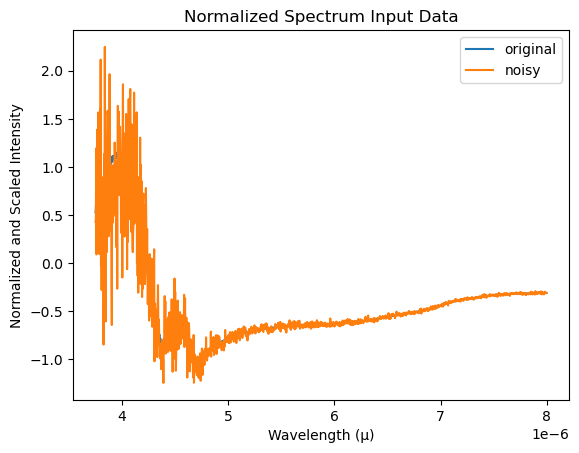

In [78]:
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [79]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [80]:
# Feature Selection

In [81]:
spec_train

tensor([[ 0.6539, -1.4546, -0.9395,  ..., -1.1378, -1.1271, -1.1174],
        [ 0.5262,  0.2306, -1.0076,  ...,  1.6783,  1.6875,  1.6711],
        [-0.3395, -0.5919, -1.1002,  ..., -0.6841, -0.6929, -0.6851],
        ...,
        [-0.9523, -0.3768, -2.4275,  ..., -0.9934, -1.0028, -1.0024],
        [ 0.8786,  1.4362,  0.8628,  ...,  0.2172,  0.2219,  0.1933],
        [ 0.2917,  0.2589, -0.2628,  ...,  1.4684,  1.4621,  1.4617]])

In [82]:
temp_train

tensor([[279.2097, 291.1372, 304.6712,  ..., 309.0874, 307.9146, 287.3898],
        [284.7944, 309.4465, 334.0897,  ..., 303.7473, 311.2545, 366.0722],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [293.5930, 300.5022, 312.8386,  ..., 306.9922, 292.7501, 293.1349],
        [337.4347, 345.6631, 344.0024,  ..., 324.8639, 323.7931, 333.0087],
        [293.4902, 286.4892, 303.6414,  ..., 345.2938, 341.2333, 361.8345]])

# Model Design

In [83]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, output_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [84]:
_, output_size = temp.shape
_, input_size = spec_noisy_scaled_df.shape

# define model
model = Net(input_size, output_size)
pred_temp = model(spec_train)


# Training Loop

In [85]:
def train_model(model, spec_train):
    print('\nTRAINING')

    loss_list = []
    
    loss_sum = 0

    num_epochs = args['training epochs']
    criterion = args['training criterion']
    optimizer = args['optimizer'](model.parameters(), lr=args['learning rate'])

    for epoch in range(num_epochs):
        pred_temp = model(spec_train)

        # calculate loss
        loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            loss_sum += loss.item()

        loss_list.append(loss.item())

        # print loss every 10% of epochs
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f'epoch: {epoch + 1}, loss = {loss}')

    print(f'inverse epoch: {epoch + 1}, inverse loss = {loss}')

    avg_training_loss = loss_sum / (num_epochs - 100)
    print(f'\naverage training loss (across all layers): {avg_training_loss}')
    
    return loss_list

In [86]:
loss_list = train_model(model, spec_train)


TRAINING
epoch: 500, loss = 4.48982572555542
epoch: 1000, loss = 4.3537092208862305
epoch: 1500, loss = 4.328550815582275
epoch: 2000, loss = 4.316271781921387
epoch: 2500, loss = 4.3043904304504395
epoch: 3000, loss = 4.295536041259766
epoch: 3500, loss = 4.286273002624512
epoch: 4000, loss = 4.2782511711120605
epoch: 4500, loss = 4.270738124847412
epoch: 5000, loss = 4.2601213455200195
inverse epoch: 5000, inverse loss = 4.2601213455200195

average training loss (across all layers): 4.359755822687733


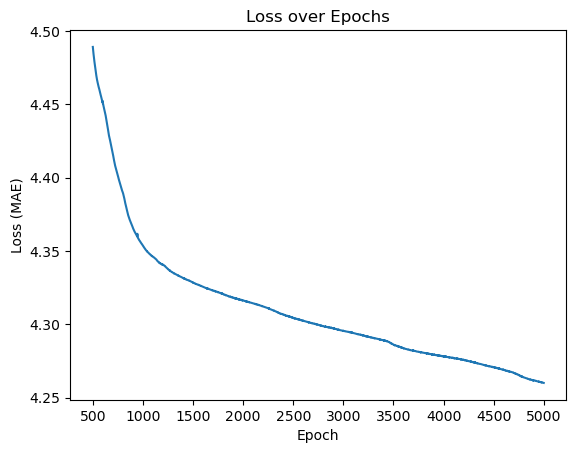

In [87]:
# plot loss over epochs

# add 500 to x-axis
x_values = range(500, args['training epochs'])
plt.plot(x_values, loss_list[500:])
plt.xticks(range(500, args['training epochs'] + 500, args['training epochs'] // 10))

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

# Testing

In [88]:
# test data
pred_temp = model(spec_test)

In [89]:
# unscale spectrum data
spec_test = scaler.inverse_transform(spec_test.detach().numpy())

In [90]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [4.685927142518939, 9.564161081025095, 5.57982099128492, 4.972699760668205, 5.117441073330966, 6.5895321701512195, 6.276019610780658, 4.584211199211352, 4.09917158647017, 5.310617712772253, 1.7613029479980469]


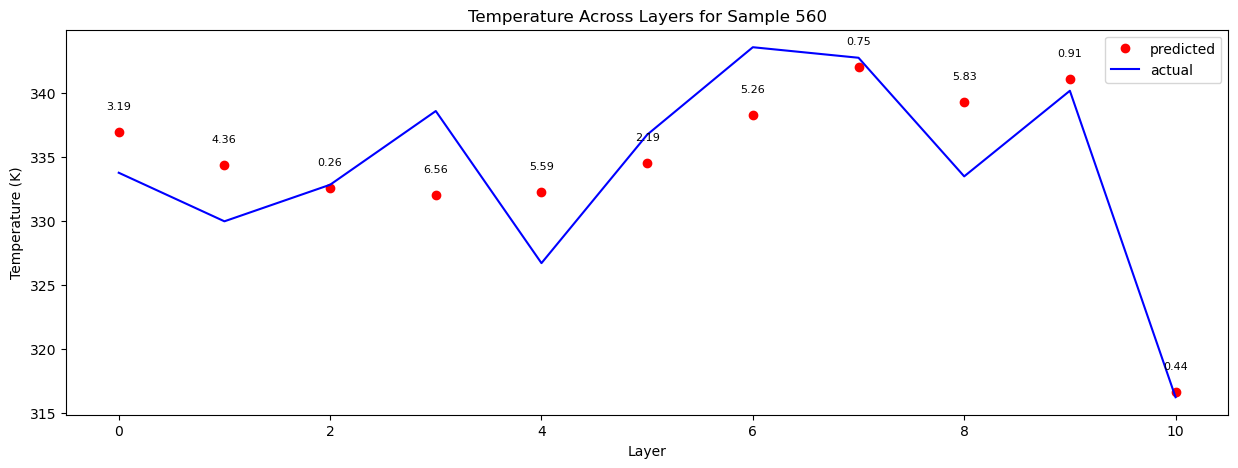

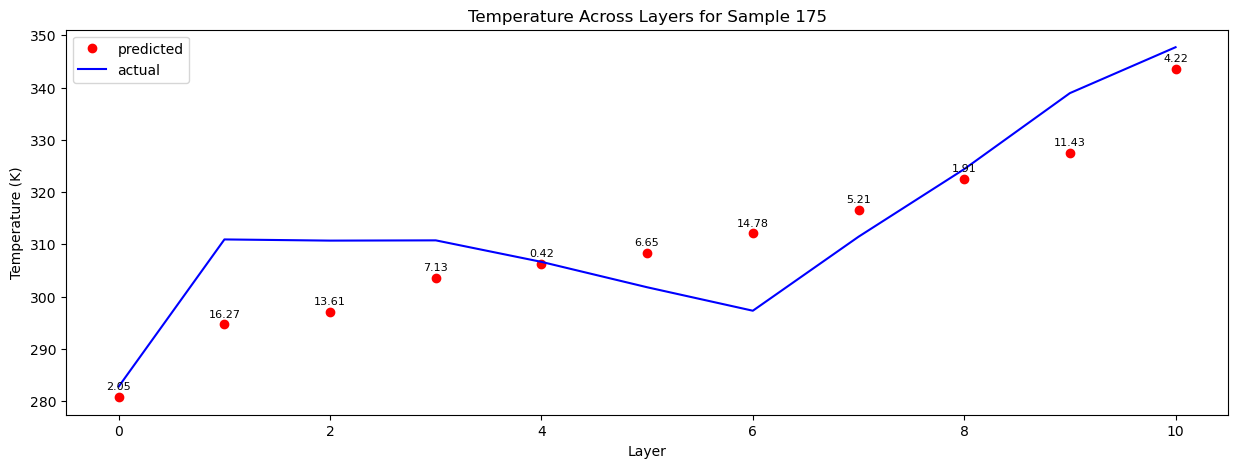

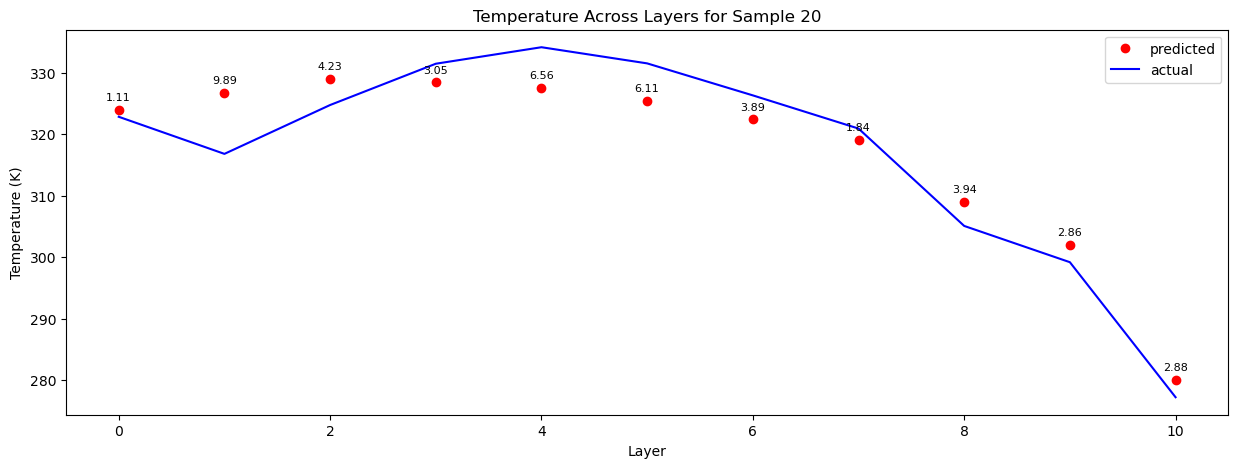

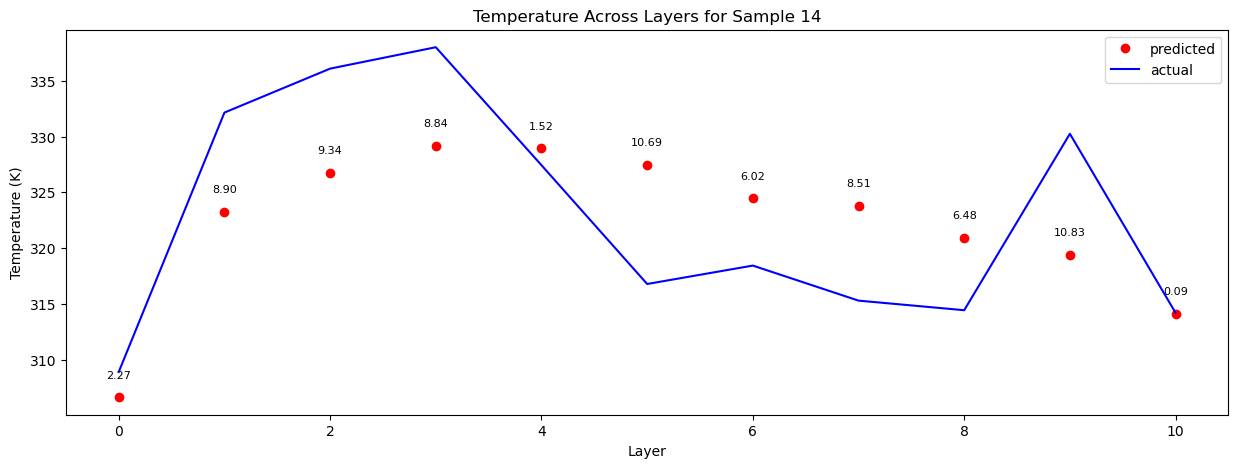

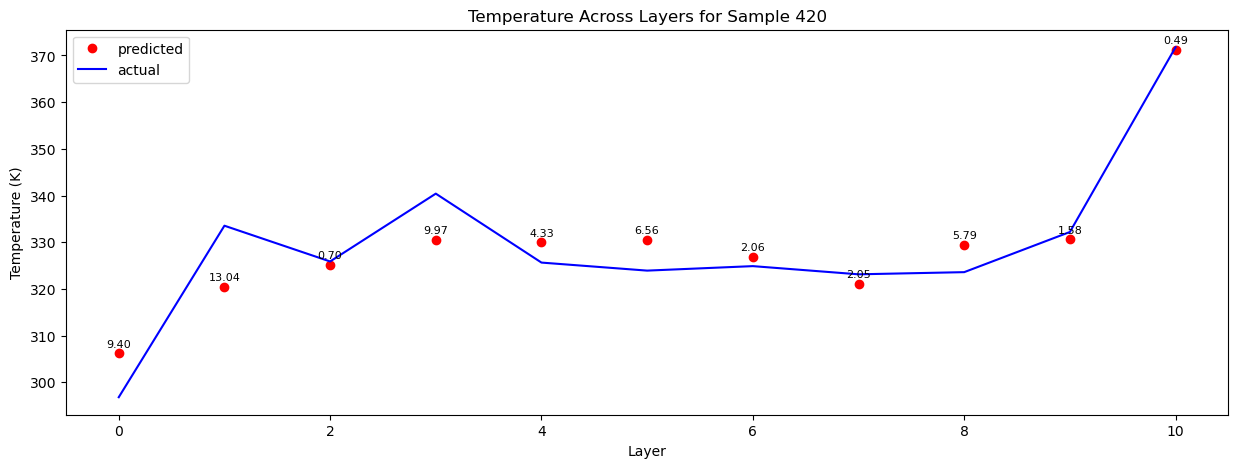

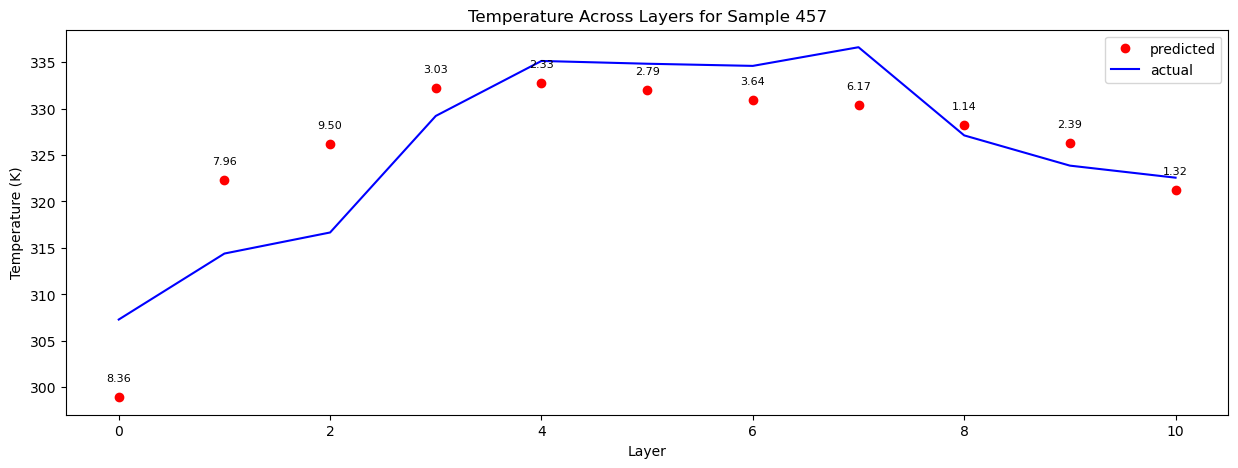

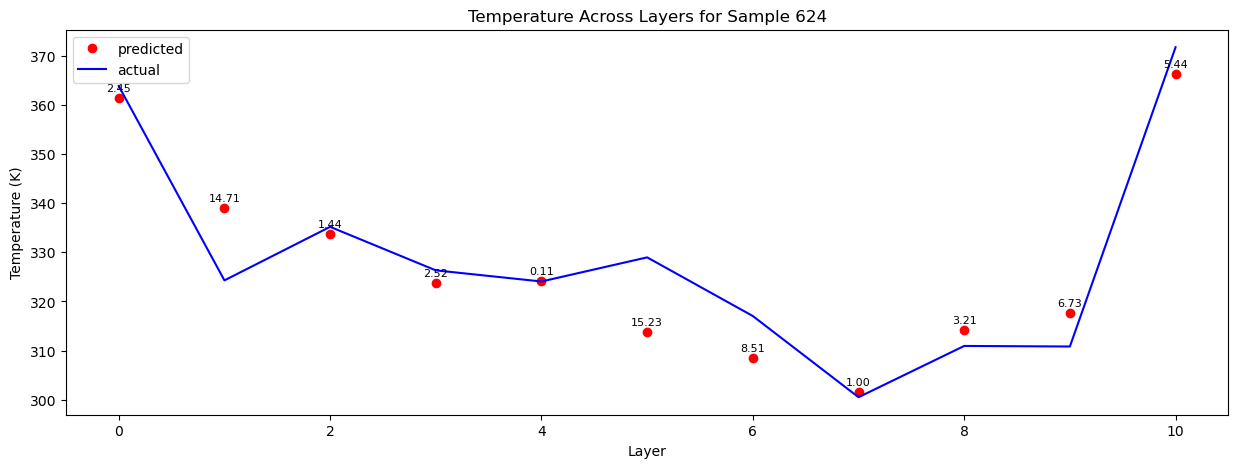

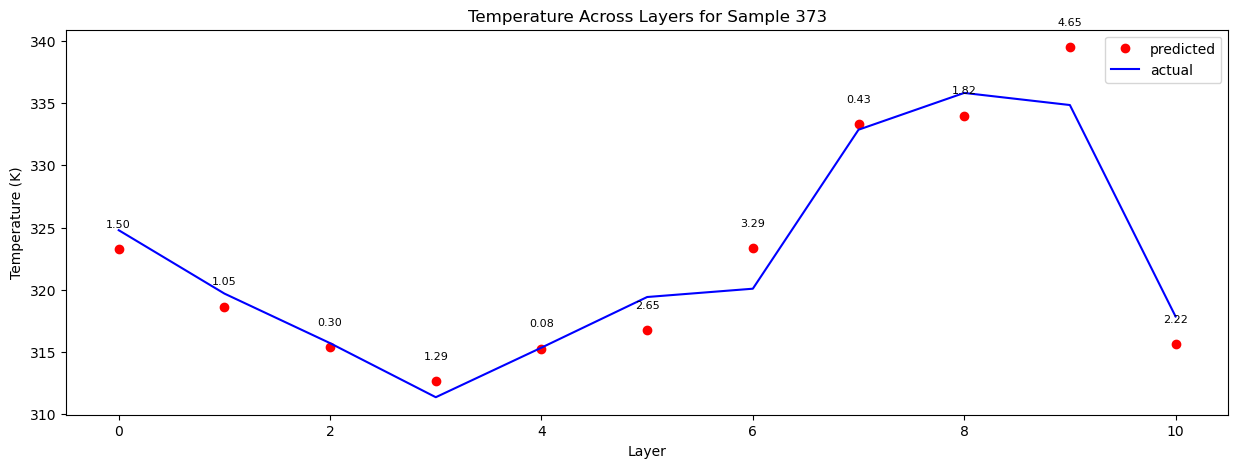

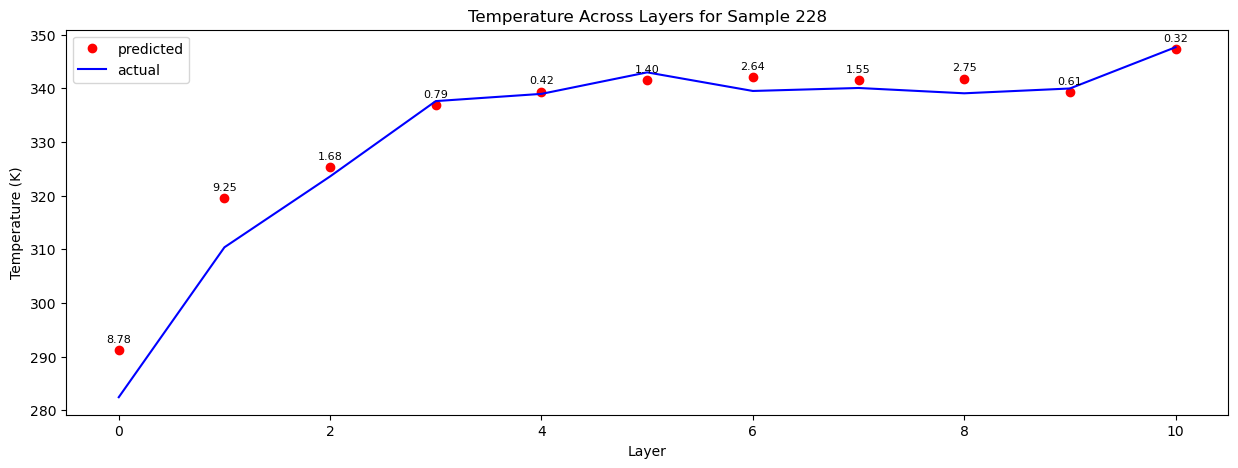

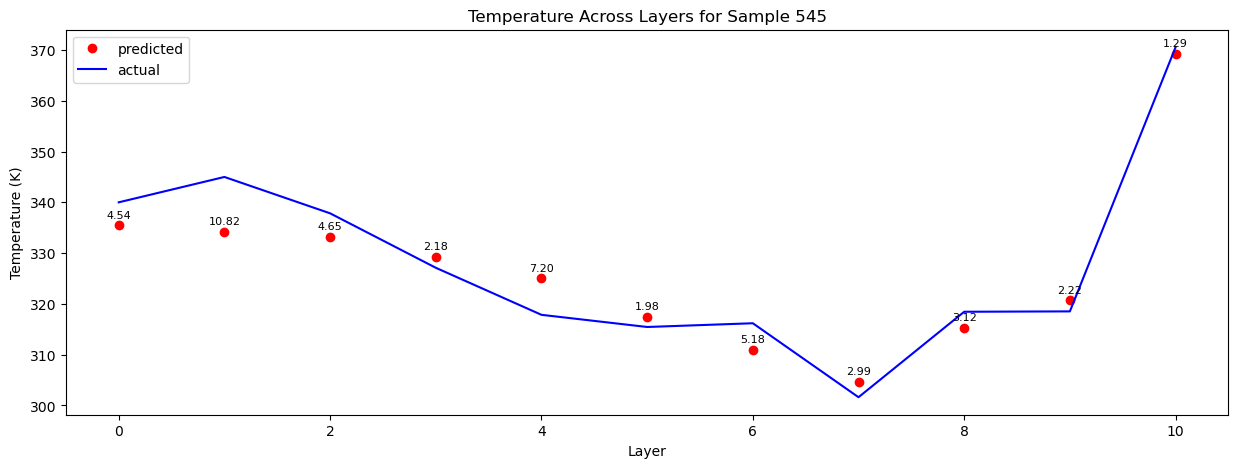

In [91]:
# find test losses and call plotting function
import random
num_graphs = 10
indices = []

test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(pred_temp)):
        # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            # print(f'layer {layer + 1} pred_temp: {pred_temp[layer]}, layer {layer + 1} temp_test: {temp_test[layer]}')
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


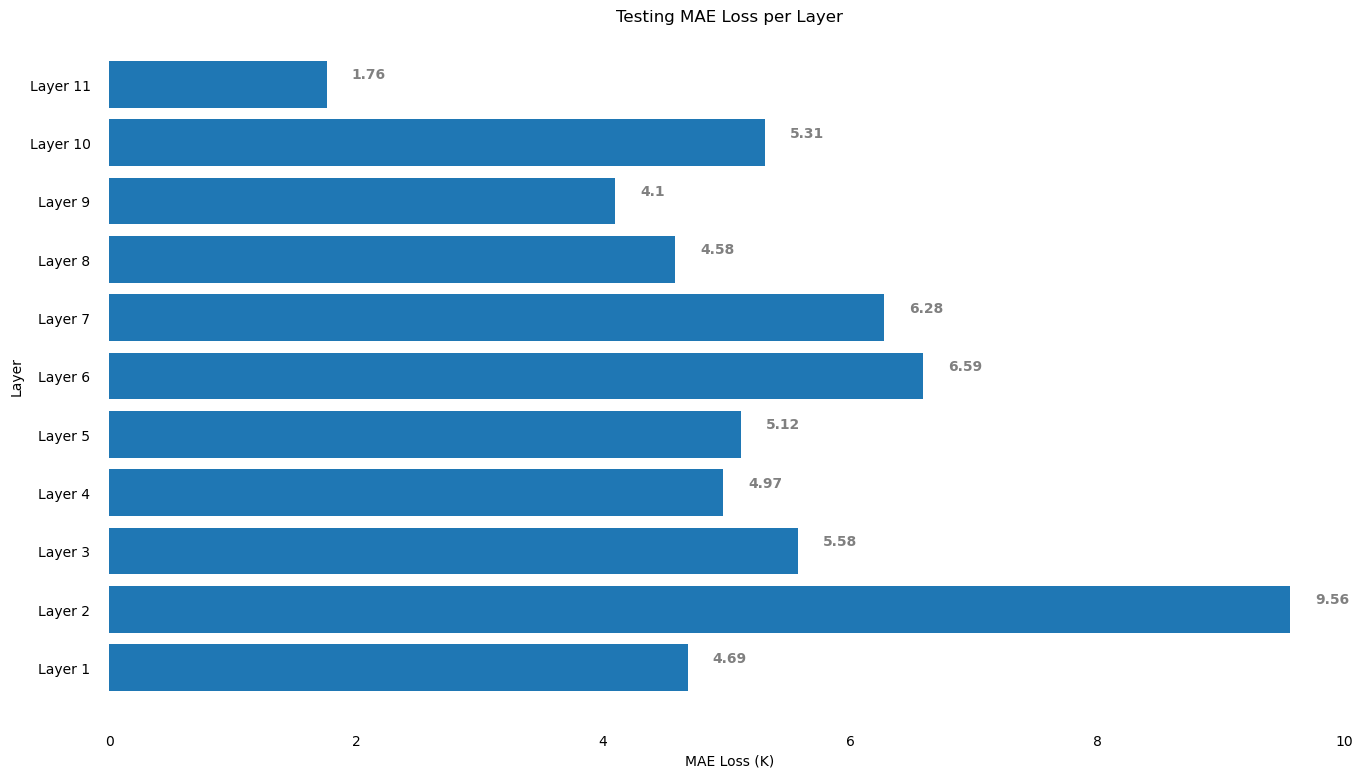

In [92]:
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, test_losses)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()